In [1]:
import numpy as np
import pandas as pd
import time
import os
from collections import defaultdict
from itertools import islice
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import heapq

from matplotlib import pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD


In [2]:
# tuning parameters for recommendation via cosine similarity...
users_per_iteration=1000                # Number of users per batch.
similar_users_count = 2             # How many similar users to be found ?
number_of_recommended_movies = 5    # How many movies to be recommended per user?
rating_threshold = 4                # only consider movies with ratings >= N for recommendation.
minimum_movies_rated = 4            # consider only users who have rated at least N movies.



In [3]:
# tuning parameters for svd based movie recommendation...
benchmark_quantile = 0.7    # do not consider movies having less than 70 percentile votes
records_per_iteration=1000000                # Number of records per batch.


In [4]:

output_file_svd = "./recommendations-svd.txt"
output_file_cosine = "./recommendations-cosine.txt"
csv_files = ['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt']
data_types = {'user_id': 'int32', 'movie_id': 'int16', 'rating': 'int8'}


In [5]:
def read_movie_titles():
    rows = []
    keys = ['movie_id', 'release_year', 'movie_title']
    with open('movie_titles.csv', encoding='iso-8859-1') as f:
      for line in f.read().splitlines():
        rows.append(dict(zip(keys, line.split(',', 2))))
    return pd.DataFrame(rows)


def get_ratings_data():
    start_time = time.time()

    sorted_user_ratings_file = "sorted_user_ratings.csv"
    if not os.path.isfile(sorted_user_ratings_file):

        unsorted_user_ratings_file = "unsorted_user_ratings.csv"
        if not os.path.isfile(unsorted_user_ratings_file):
            print("combining movie ratings data...")
            print("this may take 10+ minutes on the initial run, subsequent runs should be fast.")
            movie_id=-1

            with open(unsorted_user_ratings_file, "w+", encoding='iso-8859-1') as f_out:
                f_out.write("user_id,movie_id,rating\n")
                for file in csv_files:
                    print("{}".format(file))
                    with open(file, 'r', encoding='iso-8859-1') as f:
                        for line in f.read().splitlines():
                            if line.endswith(':'):
                                movie_id = line.split(':')[0]
                            else:
                                fields = line.split(',')
                                f_out.write("{},{},{}\n".format(fields[0], movie_id, fields[1]))

        print("saving sorted user ratings to disk...")
        df = pd.read_csv(unsorted_user_ratings_file, encoding='iso-8859-1', dtype = data_types)
        
        df.sort_values('user_id', ascending=True, inplace=True, kind='quicksort')
        df.to_csv(sorted_user_ratings_file, index=False)
    else:
        df = pd.read_csv(sorted_user_ratings_file, encoding='iso-8859-1', dtype = data_types)


    end_time = time.time() 
    print("... took {:.3f} seconds".format(end_time - start_time))
    return df


def read_qualifying():
    movie_id = user_id = None
    user_ids = set()
    movie_user_mapping = defaultdict(list)
    with open("./qualifying.txt", 'r') as f:
        for line in f.read().splitlines():
            if line.endswith(':'):
                movie_id = line
            else:
                user_id, rating_date = line.split(',')
                user_ids.add(user_id)
                movie_user_mapping[movie_id].append(user_id)
    print(len(user_ids))
    print(len(movie_user_mapping))
    print(list(islice(movie_user_mapping.items(), 5)))
    return user_ids, movie_user_mapping
    

def get_random_users():
    c = list(unique_users)
    return random.sample(c, users_per_iteration)


def get_recommended_movie_ids(user_id, other_users_ids, df_subset):
    rated_by_me = set(df_subset[ (df_subset['user_id']==user_id)]['movie_id'])
    
#     print("rated by {}: {}".format(user_id, rated_by_me))
    rated_by_others = list()
    for uid in other_users_ids:
        rated_by_others.append(set(df_subset[ (df_subset['user_id']==uid) & (df_subset['rating'] >= rating_threshold) ]['movie_id']))

#     print("rated by {}: {}".format(other_users_ids, rated_by_others))

    rated_by_others_all = set.union(*rated_by_others)
#     print("all movies rated by {}: {}".format(other_users_ids, rated_by_others_all))

    # movies not rated by me, but rated by other (similar users)
    not_rated_by_me = set.difference(rated_by_others_all, rated_by_me)
#     print("not rated by {}: {}".format(user_id, not_rated_by_me))

    new_ratings = dict()
    for movie_id in not_rated_by_me:
        # add new rating by this user = mean of nearest user's ratings.
        others_ratings = []
        for ouid in other_users_ids:
#             rated = df[ (df_subset['user_id']== ouid ) & (df_subset['movie_id'] == movie_id ) ]
            rated = df_subset[ (df_subset['user_id']== ouid ) & (df_subset['movie_id'] == movie_id ) ]

            if not rated.empty:
                others_ratings.append(rated.iloc[0]['rating'])
#         print("ratings for movie_id {} by {}: {}".format(movie_id, other_users_ids, others_ratings))
        new_rating = np.mean(others_ratings)

#       df_subset[ (df_subset['user_id']==user_id) & (df_subset['movie_id']==movie_id) ]['rating'] = new_rating
        # also save this in a temp dict for top 5 picks.
        new_ratings[movie_id] = new_rating
#         print("new rating for movie {} : {:.1f}".format(movie_id, new_rating))

    # pick top N movies from the not_rated_by_me 
    rec_movies = heapq.nlargest(number_of_recommended_movies, new_ratings, key=new_ratings.get)    
    return rec_movies


def get_movie_titles(movie_ids):
    return [ df_movie[ df_movie['movie_id']==x ].iloc[0]['movie_title'] for x in movie_ids ]
    

def get_similarity_matrix(user_ratings_normalized):
    sparse_matrix = sparse.csr_matrix(user_ratings_normalized)
    similarities_sparse = cosine_similarity(sparse_matrix.transpose(), dense_output=False)
    similarities_sparse.setdiag(-1)   # set diagonal entries to lowest values to exclude self similarity.
    return similarities_sparse


def get_similar_user_ids(i, user_id, user_ids, similarities_sparse):
    col_vals = similarities_sparse.getrow(i).toarray().tolist()[0]

    # N most similar users (last element is the most similar)
    similar_records = np.argsort(col_vals)[-similar_users_count:]
    similar_user_ids = [user_ids[similar_records[j]] for j in range(len(similar_records)-1, -1, -1)]
#     similarity_score = heapq.nlargest(similar_users_count, col_vals)
#     return similar_user_ids, similarity_score
    return similar_user_ids


def plot_ratings():
    plt.figure(figsize=(12,8))
    ax = sns.countplot(x='rating', data=df)
    plt.tick_params(labelsize=15)
    plt.title("Rating Distribution")
    plt.xlabel("Number of Ratings")
    plt.show()
    

In [6]:
def recommend_by_cosine_similarity(df):
    print("output will be written to {}".format(output_file_cosine))

    with open(output_file_cosine, 'w', buffering=1) as f_out:
        while len(df) > 0:
            # take random N users (1000 by default)
            user_ids = get_random_users()

            # create a subset dataframe
            df_subset = df[ df['user_id'].isin(user_ids)]

            # remove these users from original dataframe, so we don't process them again.
            df = df[~df['user_id'].isin(user_ids)]


            # get user ratings
            user_ratings = df_subset.pivot(columns=['user_id'], index='movie_id', values='rating')

            # normalize user ratings around 0.
            user_ratings_normalized = round(user_ratings.subtract(user_ratings.mean(axis=0), axis=1))
            # drop any users that have rated only N or less movies.
            user_ratings_normalized = user_ratings_normalized.dropna(thresh=minimum_movies_rated,axis=1).fillna(0)
            print("randomly chosen {} users".format(user_ratings_normalized.shape[1]))

            # compute similarity matrix using cosine similarity, obtain a sparse matrix.
            similarities_sparse = get_similarity_matrix(user_ratings_normalized)

            # iterate the similarity matrix and find N most similar users for each user.
            for i in range(similarities_sparse.shape[1]):
                user_id = user_ids[i]
        #             similar_user_ids, similarity_score = get_similar_user_ids(i, user_id, similarities_sparse)
                similar_user_ids = get_similar_user_ids(i, user_id, user_ids, similarities_sparse)
                recommended_movies = get_recommended_movie_ids(user_id, similar_user_ids, df_subset)
                recommended_movie_titles = get_movie_titles(recommended_movies)

                print("{} ".format(user_id), end='')

        #             print("user_id: {}, similar users: {}, score: {}".format(user_id, similar_user_ids, similarity_score))
        #             print("recommended movies: {}".format(recommended_movie_titles))
        #             print("---")
                f_out.write("user_id: {}\n".format(user_id))
                f_out.write("{}".format("\n".join(recommended_movie_titles)))
                f_out.write('\n---\n')


In [13]:
def recommend_by_svd(df):
    f = ['count','mean']
    start = 0
    stop = start + records_per_iteration
    
    print("output will be written to {}".format(output_file_svd))

    with open(output_file_svd, 'w', buffering=1) as f_out:
        while True:
            df_subset = pd.read_csv('./unsorted_user_ratings.csv')[start:records_per_iteration]
            start += records_per_iteration
            
            if len(df_subset) == 0:
                break

            user_ids = df_subset['user_id'].unique()
            user_ids
            df_movie_summary = df_subset.groupby('movie_id')['rating'].agg(f)
            df_movie_summary.index = df_movie_summary.index.map(int)
            df_movie_summary
            df_subset
            movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
            drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
            drop_movie_list
            print('movie minimum umber of ratings: {}'.format(movie_benchmark))

            df_cust_summary = df_subset.groupby('user_id')['rating'].agg(f)
            df_cust_summary.index = df_cust_summary.index.map(int)
            cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
            drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
            print(cust_benchmark)

            print('user minimum number of rating: {}'.format(cust_benchmark))

            reader = Reader()
            svd = SVD()
            data = Dataset.load_from_df(df_subset, reader)
            trainset = data.build_full_trainset()
            svd.fit(trainset)


            for user_id in user_ids:
                df_watched = df_subset[(df_subset['user_id'] == user_id) & (df_subset['rating'] == 5)]
                df_watched = df_watched.set_index('movie_id')
                df_watched = df_watched.join(df_movie)['movie_title']

                user_recommend = df_movie.copy()
                user_recommend = user_recommend.reset_index()
                user_recommend = user_recommend[~user_recommend['movie_id'].isin(drop_movie_list)]

                user_recommend['estimate_score'] = user_recommend['movie_id'].apply(lambda x: svd.predict(user_id, x).est)

                user_recommend = user_recommend.sort_values('estimate_score', ascending=False)
                print("{} ".format(user_id), end='')
                f_out.write("\nuser_id: {}\n".format(user_id))
                f_out.write(user_recommend.head(5)[['movie_id', 'estimate_score', 'movie_title']].to_string(index=False))
                f_out.write("\n---\n")


In [8]:
df_movie = read_movie_titles()
df_movie = df_movie.astype({'movie_id': 'int16', 'movie_title': 'str'})
df_movie

,movie_id,release_year,movie_title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [9]:
df = get_ratings_data()
df.head(n=10)

combining movie ratings data...
this may take 10+ minutes on the initial run, subsequent runs should be fast.
combined_data_1.txt
combined_data_2.txt
combined_data_3.txt
combined_data_4.txt
saving sorted user ratings to disk...
... took 262.782 seconds


,user_id,movie_id,rating
79334307,6,14358,2
34092597,6,6134,4
32652672,6,5926,4
38173947,6,6797,3
20618167,6,3905,3
99601160,6,17560,3
75553656,6,13651,3
40752419,6,7230,5
21282866,6,3962,4
69300001,6,12560,3


In [10]:
unique_users = df['user_id'].unique()
unique_movies = df['movie_id'].unique()
print("unique users: {}, unique movies: {}".format(len(unique_users), len(unique_movies)))
print("total records: {}".format(len(df)))

unique users: 480189, unique movies: 17770
total records: 100480507


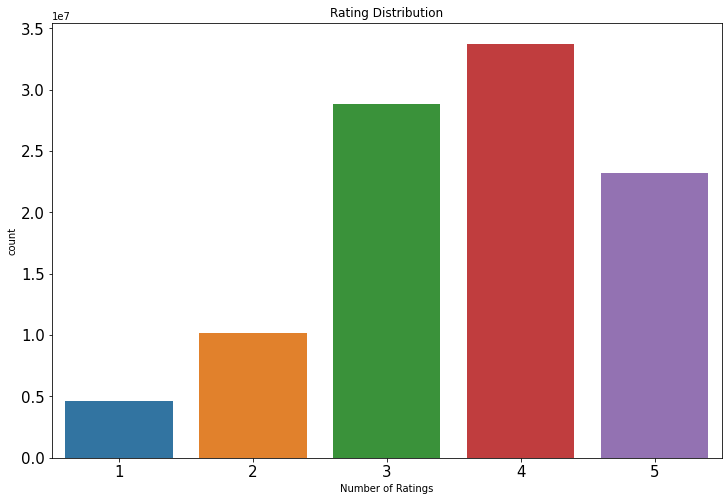

In [11]:
plot_ratings()

In [14]:
recommend_by_svd(df)

output will be written to ./recommendations-svd.txt
movie minimum umber of ratings: 1385.0
4.0
user minimum number of rating: 4.0
1488844 822109 885013 30878 823519 893988 124105 1248029 1842128 2238063 1503895 2207774 2590061 2442 543865 1209119 804919 1086807 1711859 372233 1080361 1245640 558634 2165002 1181550 1227322 427928 814701 808731 662870 337541 786312 1133214 1537427 1209954 2381599 525356 1910569 2263586 2421815 1009622 1481961 401047 2179073 1434636 93986 1308744 2647871 1905581 2508819 1578279 1159695 2588432 2423091 470232 2148699 1342007 466135 2472440 1283744 1927580 716874 4326 1546549 1493697 880166 535396 494609 1961619 883478 793564 1567202 573537 1972040 1838912 411705 2244518 584542 667730 2488120 1926776 38052 1196100 314933 1792741 769643 2477242 1421006 729846 1719610 1696031 1817215 406057 636262 1245406 1834590 593225 1011918 1665054 2630337 1155747 2439493 479924 530789 765860 231001 1493615 1850615 68959 147386 624035 782308 1116080 421374 1158759 1025798

In [15]:
recommend_by_cosine_similarity(df)

output will be written to ./recommendations-cosine.txt
randomly chosen 995 users


1146040 463227 2073145 1558018 1044726 1634146 263736 1225463 2207181 1127170 1022792 2618384 984932 1068841 360631 2360534 1652429 977069 2170322 1449019 2267852 92648 2425123 163803 394462 356206 230337 1890329 1044447 149560 2211883 630708 1627244 1834500 1168130 2181633 2512925 1029003 2328255 331495 888282 209790 2598811 2044094 606142 2358874 1883139 1895642 1354761 1499379 2138410 1234128 1654145 158980 162443 1162606 632140 2608114 1582588 2456656 201499 1151234 2361188 80139 889982 654636 280327 229532 437686 1377655 1955222 2568895 1155304 1636329 1163886 415366 2177221 2208011 1735978 1641844 1948594 106680 2058752 597384 695209 2368081 1632591 2146282 1419948 465763 176377 1333208 391966 2586375 1469340 1142321 2569171 1555170 907649 447812 667673 1903587 2574775 1542509 458104 350911 2311017 1071664 1169583 725615 2322281 1536175 2532095 132911 1376933 2391291 465226 1213884 1721741 2573934 1468519 310939 2194494 1418171 763502 1354927 1042361 70666 465297 458557 1526905 2

In [ ]:
df